In [1]:
import pandas as pd

### Combine fake.csv and true.csv //first dataset 

In [2]:
df_fake = pd.read_csv('datasets/Fake.csv')
df_true = pd.read_csv('datasets/True.csv')
df_fake_or_real = pd.read_csv('datasets/fake_or_real_news.csv')
df_fake_corpus = pd.read_csv('datasets/news_sample.csv')

df_fake.insert(4, 'label', 'fake')
df_true.insert(4, 'label', 'real')

df_fake_true = pd.concat([df_fake, df_true])

df_fake_true.reset_index(drop=True, inplace=True)

# print(df_fake_true.to_string())

### Filter and clean data //separately

In [3]:
# first dataset

# Remove unnecessary columns
df_fake_true.drop(['subject', 'date'], axis=1, inplace=True)

In [4]:
# second dataset

# Remove unnecessary columns
df_fake_or_real.drop(df_fake_or_real.columns[0], axis=1, inplace=True)

df_fake_or_real['label'].replace(['FAKE','REAL'], ['fake', 'real'], inplace=True)

# print(df_fake_or_real.to_string())

In [5]:
#third dataset

# Remove rows with invalid values
df_fake_corpus.drop(df_fake_corpus.index[(df_fake_corpus['type'] == 'unreliable') |
                                        (df_fake_corpus['type'] == 'satire') |
                                        (df_fake_corpus['type'] == 'bias') |
                                        (df_fake_corpus['type'] == 'state') |
                                        (df_fake_corpus['type'] == 'conspiracy') |
                                        (df_fake_corpus['type'] == 'junksci') |
                                        (df_fake_corpus['type'] == 'hate') |
                                        (df_fake_corpus['type'] == 'clickbait') |
                                        (df_fake_corpus['type'] == 'unknown') |
                                        (df_fake_corpus['type'] == 'political')], inplace=True)

# Remove unnecessary columns
df_fake_corpus.drop([df_fake_corpus.columns[0], 'id', 'domain', 'url', 'scraped_at' ,'inserted_at','updated_at',
                     'authors','keywords','meta_keywords','meta_description','tags','summary'],
                   axis=1, inplace=True)

# Rename columns
df_fake_corpus.rename(columns = {'type' : 'label', 'content': 'text'}, inplace=True)

# Rename label
df_fake_corpus['label'].replace(['reliable'],['real'], inplace=True)

# print(df_fake_corpus['label'].unique())
# print(df_fake_corpus.to_string())


### Filter and clean data //all together

In [6]:
# Combine all together
df_complete = pd.concat([df_fake_true, df_fake_or_real, df_fake_corpus])

df_complete.reset_index(drop=True, inplace=True)

# print(df_complete.to_string())

In [7]:
# Remove duplicates

# df_complete.columns

df_complete.nunique()
df_complete.shape

duplicates = df_complete.duplicated(subset=['title', 'text'], keep="first")
# print(duplicates)
df_complete.drop_duplicates(subset=['title', 'text'], inplace=True, keep="first")

# print and remove blank value
blank = df_complete.isna().any(axis=1).sum()
# print(blank)
df_complete.dropna(inplace = True)
blank_2 = df_complete.isna().any(axis=1).sum()
# print(blank_2)

### FIRST METHOD NAIVE BAYES

### Preparation of text - lemmatization

In [8]:
import spacy
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def preprocess_text(text):
    parsed = nlp(text)
#     print(parsed)
    lemmas = [token.lemma_.lower() for token in parsed if not token.is_stop]
    return " ".join(lemmas)
df_complete.iloc[1]['text']
# print(df_complete.iloc[1]['text'])
# print('/n/n/n')
txt = preprocess_text(df_complete.iloc[1]['text'])
# print(txt)


### Preparation of text - stemming to do

### Spliting into train, valid and test

In [9]:
from sklearn.model_selection import train_test_split
# 60% train, 20% valid, 20% test
X_train, X_test, y_train, y_test = train_test_split(df_complete['text'], df_complete['label'], test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(df_complete['text'], df_complete['label'], test_size=0.25, random_state=1)

In [10]:
# Vectorazing by creating bag-of-words features

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
X_valid_vect = vectorizer.transform(X_valid)

In [12]:
# Training Naïve Bayes Classifier

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
clf
MultinomialNB()
clf.fit(X_train_vect, y_train)
MultinomialNB()

MultinomialNB()

In [14]:
# Predictions

In [15]:
y_pred = clf.predict(X_test_vect)
y_pred
print(y_pred)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

['fake' 'real' 'fake' ... 'fake' 'fake' 'fake']
Accuracy: 0.9140882159315339


In [16]:
# Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[3848  436]
 [ 347 4483]]


<Axes: >

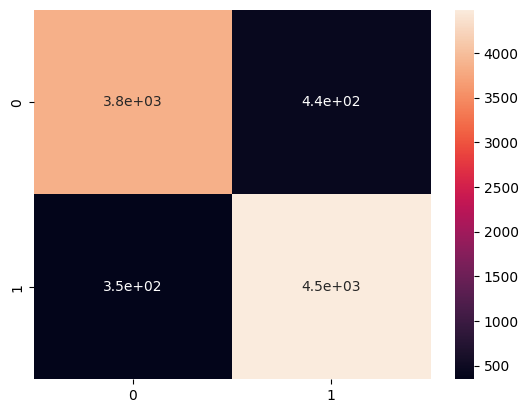

In [18]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [19]:
# Classification Report

In [20]:
from sklearn.metrics import classification_report
target_names = ['true', 'fake']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        true       0.92      0.90      0.91      4284
        fake       0.91      0.93      0.92      4830

    accuracy                           0.91      9114
   macro avg       0.91      0.91      0.91      9114
weighted avg       0.91      0.91      0.91      9114



### SECOND METHOD

In [21]:
# from gensim.models import Word2Vec
# from nltk.stem.porter import PorterStemmer

# ps = PorterStemmer()
# corpus = []
# words = []
# for i in range(0,len(df)):
#     review = re.sub('[^a-zA-Z0-9]',' ',df['title'][i])
#     review = review.lower()
#     review = review.split()
#     review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
#     statements = ' '.join(review)
#     corpus.append(statements)
#     words.append(review)
                 
# word2vec = Word2Vec(words, min_count=1)

In [22]:
# from gensim.models import Word2Vec
# from konlpy.tag import Mecab

# tokenizer = Mecab()
# def text_preprocessing(text,tokenizer):
#     txt = re.sub('[^a-zA-Z]', ' ', text)
#     token = tokenizer.morphs(txt)
#     token = [t for t in token if t not in stop_words]   
#     return token

# for i in range(len(data['text'])):
#     tmp=text_preprocessing(data['text'][i].lower(),tokenizer)
#     data['clean_text'][i]=tmp
    


In [24]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNeighborsClassifier model
knn = KNeighborsClassifier(n_neighbors=5)
# Fit the model
knn.fit(X_train_vect, y_train)
# Use the trained model to predict
y_pred = knn.predict(X_test_vect)
# model accuracy
print(f'Model train accuracy: {knn.score(X_train_vect, y_train)*100:.3f}%')
print(f'Model test accuracy: {knn.score(X_test_vect, y_test)*100:.3f}%')
print(f'Model test precision: {precision_score(y_pred,y_test):.3f}')
print(f'Model test recall: {recall_score(y_pred,y_test):.3f}')
print(f'Model test f1_score: {f1_score(y_pred,y_test):.3f}')

Model train accuracy: 90.578%
Model test accuracy: 86.406%


NameError: name 'precision_score' is not defined

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score,classification_report
print(f'Model test precision: {precision_score(y_test, y_pred, pos_label="real"):.3f}')
print(f'Model test recall: {recall_score(y_test, y_pred, pos_label="real"):.3f}')
print(f'Model test f1_score: {f1_score(y_test, y_pred, pos_label="real"):.3f}')


Model test precision: 0.848
Model test recall: 0.905
Model test f1_score: 0.876
